# Deblur Photos with DeblurGAN-v2 and OpenVINO™

This tutorial demonstrates Single Image Motion Deblurring with DeblurGAN-v2 in OpenVINO, by first converting the [VITA-Group/DeblurGANv2](https://github.com/VITA-Group/DeblurGANv2) model to OpenVINO Intermediate Representation (OpenVINO IR) format. For more information about the model, see the [documentation](https://docs.openvino.ai/latest/omz_models_model_deblurgan_v2.html).

### What is deblurring?

Deblurring is the task of removing motion blurs that usually occur in photos shot with hand-held cameras when there are moving objects in the scene. Blurs not only reduce the human perception about the quality of the image, but also complicate computer vision analyses. 

For more information, refer to the following research paper:

Kupyn, O., Martyniuk, T., Wu, J., & Wang, Z. (2019). [Deblurgan-v2: Deblurring (orders-of-magnitude) faster and better.](https://openaccess.thecvf.com/content_ICCV_2019/html/Kupyn_DeblurGAN-v2_Deblurring_Orders-of-Magnitude_Faster_and_Better_ICCV_2019_paper.html) In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 8878-8887).

## Preparations

### Imports

In [1]:
import json
import shutil
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Markdown, display
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import load_image

### Settings

In [2]:
# A device to use for inference. For example, "CPU", or "GPU".
DEVICE = "CPU"

# A directory where the model will be downloaded.
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# The output directory.
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# The name of the model from Open Model Zoo.
model_name = "deblurgan-v2"
model_xml_path = model_dir / Path(f"{model_name}.xml")

precision = "FP16"
base_model_dir = Path("~/open_model_zoo_models").expanduser()
omz_cache_dir = Path("~/open_model_zoo_cache").expanduser()

### Download DeblurGAN-v2 Model from Open Model Zoo

In [3]:
download_command = (
    f"omz_downloader --name {model_name} --output_dir"
    f" {base_model_dir} --cache_dir {omz_cache_dir}"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {model_name}..."))
! $download_command

Download command: `omz_downloader --name deblurgan-v2 --output_dir C:\Users\97798\open_model_zoo_models --cache_dir C:\Users\97798\open_model_zoo_cache`

Downloading deblurgan-v2...

################|| Downloading deblurgan-v2 ||################

========== Downloading C:\Users\97798\open_model_zoo_models\public\deblurgan-v2\models\__init__.py

========== Downloading C:\Users\97798\open_model_zoo_models\public\deblurgan-v2\models\fpn_mobilenet.py
... 100%, 5 KB, 347 KB/s, 0 seconds passed

========== Downloading C:\Users\97798\open_model_zoo_models\public\deblurgan-v2\models\mobilenet_v2.py
... 100%, 4 KB, ? KB/s, 0 seconds passed

========== Downloading C:\Users\97798\open_model_zoo_models\public\deblurgan-v2\models\networks.py
... 100%, 12 KB, ? KB/s, 0 seconds passed

========== Downloading C:\Users\97798\open_model_zoo_models\public\deblurgan-v2\ckpt\fpn_mobilenet.h5
... 7%, 1024 KB, 85 KB/s, 11 seconds passed
... 15%, 2048 KB, 91 KB/s, 22 seconds passed
... 23%, 3072 KB, 110 KB/s, 27 seconds passed
... 31%, 4096 KB, 134 KB/s, 30 seconds passed
... 38%, 5120 KB, 155 KB/s, 32 seconds passed
... 46%, 6144 KB, 177 KB/s, 34 seconds passed
... 54%, 7168 KB, 199 KB/s

### Convert DeblurGAN-v2 Model to OpenVINO IR format

Model Conversion may take a while. When the conversion succeeds, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model`.

In [4]:
convert_command = (
    f"omz_converter --name {model_name} --precisions {precision} "
    f"--download_dir {base_model_dir} --output_dir {base_model_dir}"
)
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {model_name}..."))

! $convert_command

Convert command: `omz_converter --name deblurgan-v2 --precisions FP16 --download_dir C:\Users\97798\open_model_zoo_models --output_dir C:\Users\97798\open_model_zoo_models`

Converting deblurgan-v2...

========== Converting deblurgan-v2 to ONNX
Conversion to ONNX command: C:\Users\97798\openvino_en\Scripts\python.exe -- C:\Users\97798\openvino_en\lib\site-packages\openvino\model_zoo\internal_scripts\pytorch_to_onnx.py --model-path=C:\Users\97798\openvino_en\Lib\site-packages\openvino\model_zoo\models\public\deblurgan-v2 --model-path=C:\Users\97798\open_model_zoo_models\public\deblurgan-v2 --model-name=DeblurV2 --import-module=model --input-shape=1,3,736,1312 --output-file=C:\Users\97798\open_model_zoo_models\public\deblurgan-v2/deblurgan-v2.onnx "--model-param=weights=r\"C:\Users\97798\open_model_zoo_models\public\deblurgan-v2/ckpt/fpn_mobilenet.h5\"" "--model-param=model_name=\"fpn_mobilenet\"" --input-names=blur_image --output-names=deblur_image

ONNX check passed successfully.

========== Converting deblurgan-v2 to IR (FP16)
Conversion command: C:\Users\97798\openvino_en\Scripts\python.exe -- C:\Users\97798\openvino_en\Scripts\mo.exe --framework=onnx --data_type=FP16 --output_dir=

### Copy the Model

Copy the DeblurGAN-v2 Model to the specified `model_dir` directory in the settings.

In [5]:
model_info = %sx omz_info_dumper --name $model_name

In [6]:
model_info_json = json.loads(model_info.get_nlstr())[0]

In [7]:
model_downloaded_dir = (
    base_model_dir / Path(model_info_json["subdirectory"]) / Path(precision)
)

for model_file in model_downloaded_dir.iterdir():
    try:
        shutil.copyfile(model_file, model_dir / model_file.name)
    except FileExistsError:
        pass

## Load the Model

Load and compile the DeblurGAN-v2 model in the OpenVINO Runtime with `ie.read_model` and compile it for the specified device with `ie.compile_model`. Get input and output keys and the expected input shape for the model.

In [8]:
ie = Core()
model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

In [9]:
model_input_layer = compiled_model.input(0)
model_output_layer = compiled_model.output(0)

In [10]:
model_input_layer

<ConstOutput: names[blur_image] shape{1,3,736,1312} type: f32>

In [11]:
model_output_layer

<ConstOutput: names[deblur_image] shape{1,3,736,1312} type: f32>

## Deblur Image

### Load, resize and reshape input image

The input image is read by using the default `load_image` function from `notebooks.utils`. Then, resized to meet the network expected input sizes, and reshaped to `(N, C, H, W)`, where `N` is a number of images in the batch, `C` is a number of channels, `H` is the height, and `W` is the width.

In [28]:
# Image filename (local path or URL)
filename = "https://user-images.githubusercontent.com/41332813/166901955-5d813e4c-a895-4da2-a36c-a96b3f627ebb.png"
#filename = "https://images.pexels.com/photos/1707820/pexels-photo-1707820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"


In [29]:
# Load the input image.
image = load_image(filename)

# Convert the image if it is stored in RGBA format.
image = np.asarray(Image.fromarray(image).convert('RGB'))

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = model_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

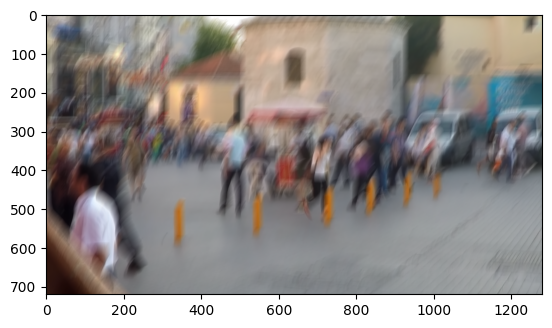

In [30]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Do Inference on the Input Image

Do the inference, convert the result to an image shape and resize it to the original image size.

In [31]:
# Inference.
result = compiled_model([input_image])[model_output_layer]

# Convert the result to an image shape.
result_image = result[0].transpose((1, 2, 0))

# Resize to the original image size.
resized_result_image = cv2.resize(result_image, image.shape[:2][::-1])

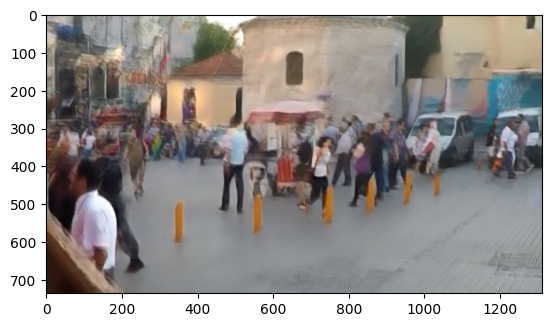

In [32]:
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

### Load the groundtruth Image

Load the groundtruth image for comparison.

In [33]:
# Load grountruth image.
groundtruth_image = load_image("https://user-images.githubusercontent.com/41332813/166900611-83be8ae5-23ed-4426-b535-fad960795687.png")

In [26]:
groundtruth_image = load_image("https://images.pexels.com/photos/1707820/pexels-photo-1707820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1")

### Display results

Images are in `BGR` format, so they will be converted to the `RGB` format in order to be properly displayed by matplotlib library.

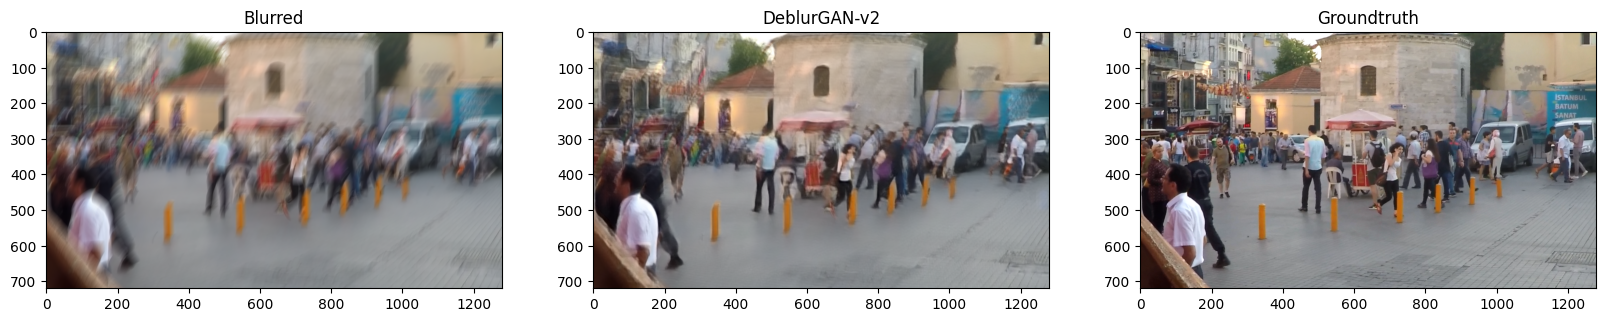

In [34]:
# Create subplot(r,c) by providing the no. of rows (r),
# number of columns (c) and figure size.
f, ax = plt.subplots(1, 3, figsize=(20, 15))

# Use the created array and display the images horizontally.
ax[0].set_title("Blurred")
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax[1].set_title("DeblurGAN-v2")
ax[1].imshow(cv2.cvtColor(resized_result_image, cv2.COLOR_BGR2RGB))

ax[2].set_title("Groundtruth")
ax[2].imshow(cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2RGB))

### Save the deblurred image

Save the output image of the DeblurGAN-v2 model in the `output_dir` directory.

In [ ]:
savename = "deblurred.png"
plt.imsave(
    output_dir / Path(savename),
    cv2.cvtColor(resized_result_image, cv2.COLOR_BGR2RGB),
)